# Steam User Interaction: Exploratory Data Analysis

Using this [dataset found from kaggle](https://www.kaggle.com/tamber/steam-video-games/data), which includes about 200,000 interactions from Steam users, which includes purchasing and playtime data. The dataset is a bit limited because it only discloses which products were purchased and how many hours of gameplay the user has, but no information about when any of these actions occur.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We begin our exploration by utilizing pandas to extract the data from the csv and allow us to flexily manipulate this data.

The columns didn't have a header, so the column names were added according to the kaggle page. Also, note that the final column is only comprise of 0's, and has no significance, so it was dropped.

In [2]:
#names to assign to columns
column_names = ['user-id','game-title','behavior-name','value']

#dtypes to assign
dtypes = {'user-id':int, 'game-title':str, 'behavior-name':'category', 'value':np.float64}

#read in data from csv (please adjust path if you want to run this). Dropped last column because useless
df = pd.read_csv('./steam-200k.csv', 
                usecols=[0,1,2,3],
                names=column_names)

In [3]:
df.head()

,user-id,game-title,behavior-name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


I want to clear up some things about this dataset; the first I'm curious about, "does every play behavior HAVE to have a purchase behavior?"

We'll do this for one user and then iterate amoungst all users.

In [4]:
#boolean mask to extract only for one user
user_mask = df['user-id'] == 151603712

#dataframe is filter according to the mask above (i.e.) only transactions from user: 151603712
ind_user_df = df[user_mask]

#creates masks to seperate purchase and play data
purchase_only = ind_user_df['behavior-name'] == 'purchase'
play_only = ind_user_df['behavior-name'] == 'play'

#uses masks to split
ind_purch_df= ind_user_df[purchase_only]
ind_play_df = ind_user_df[play_only]

#creates list of unique values
ind_purch_list = list(ind_purch_df['game-title'].unique())
ind_play_list = list(ind_play_df['game-title'].unique())

#Is every game played purchased?
check = [game in ind_purch_list for game in ind_play_list]
print(all(check))
print(check)

True
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


It appears that for the user in question, all games that they played have a corresponding purchased entry. In the next cell, the code is converted into a function, and the cell following iterates through all users.

In [5]:
def allplayedpurchased(userid):    
    
    #boolean mask to extract only for one user
    user_mask = df['user-id'] == userid

    #dataframe is filter according to the mask above (i.e.) only transactions from user: 151603712
    ind_user_df = df[user_mask]

    #creates masks to seperate purchase and play data
    purchase_only = ind_user_df['behavior-name'] == 'purchase'
    play_only = ind_user_df['behavior-name'] == 'play'

    #uses masks to split
    ind_purch_df= ind_user_df[purchase_only]
    ind_play_df = ind_user_df[play_only]

    #creates list of unique values
    ind_purch_list = list(ind_purch_df['game-title'].unique())
    ind_play_list = list(ind_play_df['game-title'].unique())

    #Is every game played purchased?
    check = all(game in ind_purch_list for game in ind_play_list)
    return check

In [6]:
unique_user_ids = list(df['user-id'].unique())

confirmed_users = {}
for user in unique_user_ids:
    confirmed_users[user] = allplayedpurchased(user)

print(all(confirmed_users))

True


Our function confirmed that every played game will have a corresponding purchased data entry. The converse is of courese not true, because plenty of people have game in steam that they haven't played.

Next, lets create new tables which split the data into more useful views:

-a table with user stats based off data, splitting up the columns to describe habits in both

-a table with game stats based off data, one based on purchases, another based on play

First, we'll create the user-based tables:

In [7]:
#create masks to split purchases and play
purch_mask = df['behavior-name'] == 'purchase'
play_mask = df['behavior-name'] == 'play'

#creates 2 new dataframes by splitting original
purch_df = df[purch_mask]
play_df = df[play_mask]

purch_df

,user-id,game-title,behavior-name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
2,151603712,Fallout 4,purchase,1.0
4,151603712,Spore,purchase,1.0
6,151603712,Fallout New Vegas,purchase,1.0
8,151603712,Left 4 Dead 2,purchase,1.0
...,...,...,...,...
199990,128470551,Fallen Earth,purchase,1.0
199992,128470551,Magic Duels,purchase,1.0
199994,128470551,Titan Souls,purchase,1.0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0


We'll likely be interested in know how many games each user bought as well as how many games they've played and how many hours they have total. This next cell will prepare these columns as pandas.series

In [8]:
#number of games purchased aggregated per user-id
purchased_game_count = purch_df.groupby('user-id').count()['game-title'].rename('purchased-game-count')

#number of unique games played, and total hours played amoungst all games
played_game_count = play_df.groupby('user-id').count()['game-title'].rename('played-game-count')
played_hours_count = play_df.groupby('user-id')['value'].sum().rename('played-hours-count')


This next set of cells start grouping up each dataframe by user to create aggregate information on each user.

The first creates lists of games purchased and games played
The second cell creates a fraction of games played to games purchased 
The third extracts the mean, standard deviation, and max hours played accross their played titles
The forth and fifth create a column with the game title for their most played gamed, if they have played games.

In [9]:
#makes a list of all games purchased
purchased_gametitle_list = purch_df.groupby('user-id').apply(lambda x: list(x['game-title'])).rename('purhased-gametitles-list')

#makes a list of all games played at least once
play_gametitle_list = play_df.groupby('user-id').apply(lambda x: list(x['game-title'])).rename('played-gametitles-list')

In [10]:
#This two lines create column with fraction of games played out of purchased. then fills Nan with 0%
percent_library_played = (played_game_count/purchased_game_count).rename('percent-library-played')
percent_library_played.fillna(0, inplace=True)

In [11]:
#the averge number of hours per game for the user, and the standard deviation
played_hours_avg = play_df.groupby('user-id')['value'].mean().rename('played-hours-avg')
played_hours_std = play_df.groupby('user-id')['value'].std().rename('played-hours-std').fillna(0)
played_hours_max = play_df.groupby('user-id')['value'].max().rename('played-hours-max').fillna(0)

In [12]:
#the most played game for the user
most_played_game_idx = play_df.groupby('user-id')['value'].idxmax()

user_index = most_played_game_idx.index

In [13]:
#fills in most played title per each user
most_played_game = pd.Series(name='most-played-game', index=user_index)
for user, idx in most_played_game_idx.items():
    most_played_game[user] = df.iloc[idx, 1]

In the next cell, the multiple series we create above all get horizontally concatenated to make a dataframe.

The cells following fill in Null values that generate for users who purchased games but never played any, and then to convert the data type, and give empty list for users who never played game for the "played-gametitles-list".

In [14]:
#create a list of pd.Series we will combine for dataframe
columns_to_join_users = [purchased_game_count,
                         played_game_count,
                         played_hours_count,
                         purchased_gametitle_list,
                         play_gametitle_list,
                         percent_library_played,
                         played_hours_avg,
                         played_hours_std,
                         played_hours_max,
                         most_played_game]
#combines series into one dataframe
users_stats_df = pd.concat(columns_to_join_users, axis=1)

In [15]:
#fills in null values (excluding played-gametitles-list)
fillna_dict_users = {'played-game-count':0,
                    'played-hours-count':0,
                    'played-hours-avg':0,
                    'played-hours-std':0,
                    'played-hours-max':0,
                    'most-played-game':''}

users_stats_df.fillna(fillna_dict_users, inplace=True)

In [16]:
#users who have purchased games but never played have a null value for the list
users_stats_df['played-gametitles-list'] = users_stats_df['played-gametitles-list'].apply(lambda d: d if isinstance(d, list) else [])

In [17]:
#converts games played count to int
users_stats_df['played-game-count'] = users_stats_df['played-game-count'].astype(int)

### User Based Aggregate Table

So we've collected some interesting statistics per user and below we displayed it one last time, then saved to a .CSV

In [18]:
users_stats_df

,purchased-game-count,played-game-count,played-hours-count,purhased-gametitles-list,played-gametitles-list,percent-library-played,played-hours-avg,played-hours-std,played-hours-max,most-played-game
user-id,,,,,,,,,,
5250,21,6,225.5,"[Cities Skylines, Deus Ex Human Revolution, Po...","[Cities Skylines, Deus Ex Human Revolution, Po...",0.285714,37.583333,57.121989,144.0,Cities Skylines
76767,36,20,1227.0,"[Counter-Strike, Call of Duty World at War, To...","[Counter-Strike, Call of Duty World at War, To...",0.555556,61.350000,104.713919,365.0,Counter-Strike
86540,82,15,255.0,"[The Elder Scrolls V Skyrim, Audiosurf, XCOM E...","[The Elder Scrolls V Skyrim, Audiosurf, XCOM E...",0.182927,17.000000,31.263900,113.0,The Elder Scrolls V Skyrim
103360,10,0,0.0,"[Counter-Strike, Counter-Strike Condition Zero...",[],0.000000,0.000000,0.000000,0.0,
144736,8,1,0.1,"[Counter-Strike, Day of Defeat, Deathmatch Cla...",[Counter-Strike],0.125000,0.100000,0.000000,0.1,Counter-Strike
...,...,...,...,...,...,...,...,...,...,...
309554670,1,1,5.9,[Mitos.is The Game],[Mitos.is The Game],1.000000,5.900000,0.000000,5.9,Mitos.is The Game
309626088,1,1,6.7,[Age of Empires II HD Edition],[Age of Empires II HD Edition],1.000000,6.700000,0.000000,6.7,Age of Empires II HD Edition
309812026,2,0,0.0,"[Counter-Strike Nexon Zombies, Robocraft]",[],0.000000,0.000000,0.000000,0.0,


In [19]:
users_stats_df.to_csv('./steam_user_aggregate_data.CSV')

Starting on the next aggregate data table, were going to reuse the sepearted play and purchase data frames.

In [20]:
purch_df

,user-id,game-title,behavior-name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
2,151603712,Fallout 4,purchase,1.0
4,151603712,Spore,purchase,1.0
6,151603712,Fallout New Vegas,purchase,1.0
8,151603712,Left 4 Dead 2,purchase,1.0
...,...,...,...,...
199990,128470551,Fallen Earth,purchase,1.0
199992,128470551,Magic Duels,purchase,1.0
199994,128470551,Titan Souls,purchase,1.0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0


In [21]:
#number of games purchased aggregated per user-id
buyer_count = purch_df.groupby('game-title').count()['user-id'].rename('buyer-count')

#number of unique games played, and total hours played amoungst all games
player_count = play_df.groupby('game-title').count()['user-id'].rename('player-count')
accumulated_hours_played = play_df.groupby('game-title')['value'].sum().rename('accumulated-hours-played')

In [22]:
#fraction of buyers that actually played the game
frac_player_of_buyer = (player_count/buyer_count).fillna(0).rename('player-frac-of-buyer')

In [23]:
#average number of hours played amoung all users
avg_hours_played = play_df.groupby('game-title')['value'].mean().rename('avg-hours-played')

In [24]:
#combine series into one df
columns_to_join_games = [buyer_count,
                         player_count,
                         accumulated_hours_played,
                         frac_player_of_buyer,
                         avg_hours_played]

games_stats_df = pd.concat(columns_to_join_games, axis=1)

C:\Users\alexr\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [25]:
#fills in null values 
fillna_dict_games = {'player-count':0,
                    'accumulated-hours-played':0,
                    'avg-hours-played':0}

games_stats_df.fillna(fillna_dict_games, inplace=True)

In [26]:
#convert dtype to int
games_stats_df['player-count'] = games_stats_df['player-count'].astype(np.int64)

### Game Based Aggregate Table

So we've collected some interesting statistics per game and below we displayed it one last time, then saved to a .CSV

In [27]:
games_stats_df

,buyer-count,player-count,accumulated-hours-played,player-frac-of-buyer,avg-hours-played
007 Legends,1,1,0.7,1.000000,0.700000
0RBITALIS,3,3,1.2,1.000000,0.400000
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),7,5,20.0,0.714286,4.000000
10 Second Ninja,6,2,5.9,0.333333,2.950000
"10,000,000",1,1,3.6,1.000000,3.600000
...,...,...,...,...,...
sZone-Online,102,58,56.7,0.568627,0.977586
samurai_jazz,1,0,0.0,0.000000,0.000000
the static speaks my name,13,8,2.0,0.615385,0.250000
theHunter,248,124,309.2,0.500000,2.493548


In [28]:
games_stats_df.to_csv('./steam_game_aggregate_data.CSV')

# Data Visualization

Utilizing seaborn statistical graphing library, I going to create a few basic graph to find any interesting insights.

We'll begin by running sns.pairplot, a fucntion that creates a grid of scatter plots between all variables, and histograms of the distribution along the diagonals. This is a quick and easy way to search through all the relationships to see if there's anything interesting. I don't expect to find anything very interesting due the nature of the columns.

In [29]:
import seaborn as sns

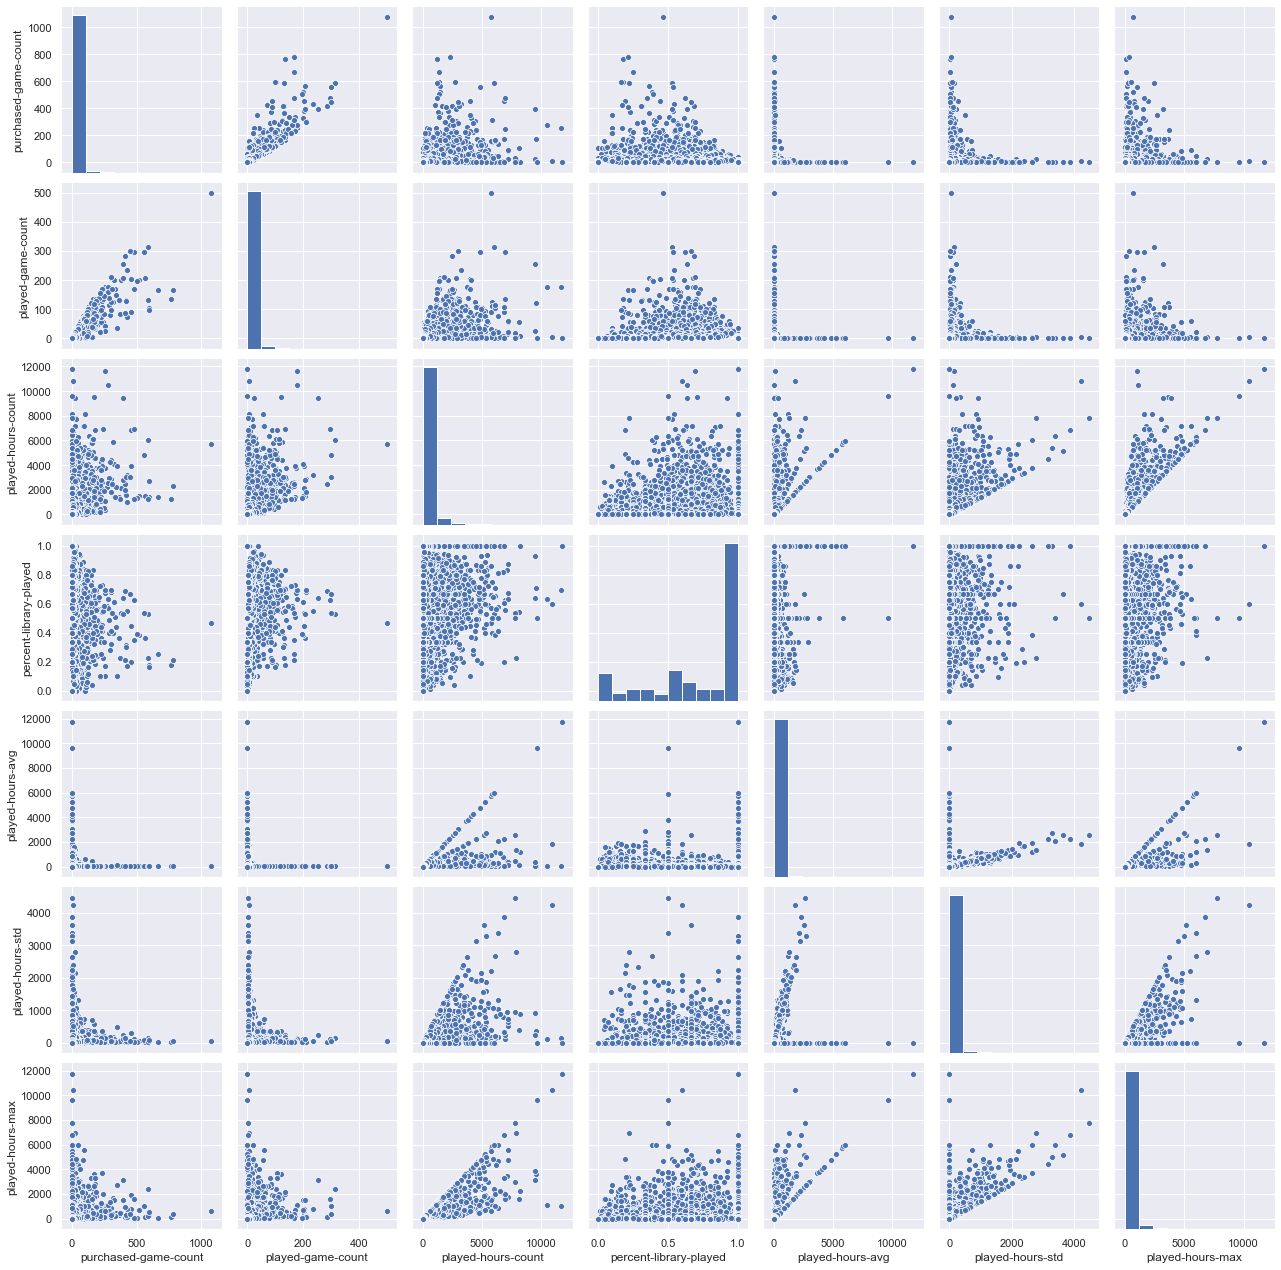

In [147]:
#sets the size of the figure to be created
sns.set(rc={'figure.figsize':(14,10)})

#creates pairplots for user data
sns.pairplot(data=users_stats_df)

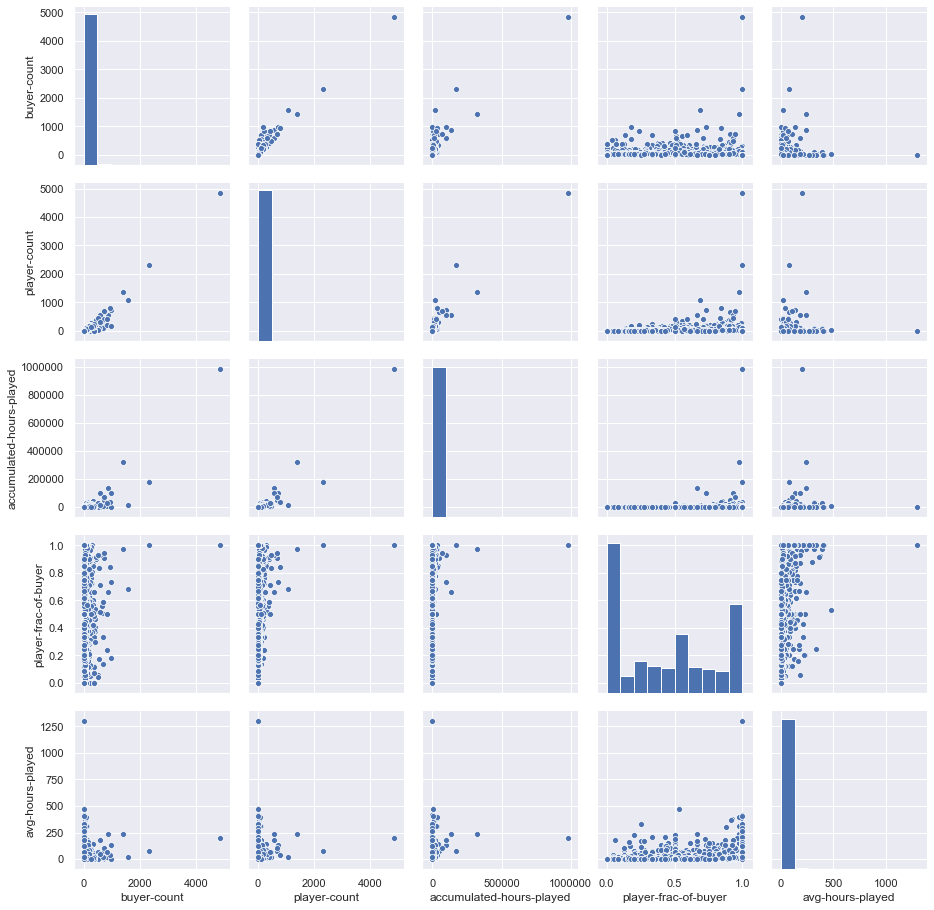

In [148]:
#create pairplot for game data
sns.pairplot(data=games_stats_df)

There is likely more insight from categorical plots.

In [114]:
games_df_head = games_stats_df.sort_values('buyer-count', ascending=False).head(15)
games_df_head["title"] = games_df_head.index
games_melt = games_df_head.melt(id_vars="title", value_vars=["buyer-count","player-count"])

sns.set(rc={'figure.figsize':(14,10)})

most_purch_game = sns.barplot(x="title",
            y="value",
            hue="variable",
            palette = "Set2",
            data=games_melt,
            ax= ax[0])

most_purch_game.set_xticklabels(most_purch_game.get_xticklabels(), rotation=85, fontsize=18)
most_purch_game.set_title('Most Purchased Games', fontsize = 24)

Text(0.5, 1, 'Most Purchased Games')

In [127]:
games_df_head = games_stats_df.sort_values('player-count', ascending=False).head(15)
games_df_head["title"] = games_df_head.index
games_melt = games_df_head.melt(id_vars="title", value_vars=["buyer-count","player-count"])

sns.set(rc={'figure.figsize':(14,10)})

most_played_game = sns.barplot(x="title",
            y="value",
            hue="variable",
            palette = "pastel",
            data=games_melt,
            ax= ax[1])

ax[1].set_xticklabels(most_played_game.get_xticklabels(), rotation=85, fontsize=18)
ax[1].set_title('Most Played Games', fontsize = 24)

Text(0.5, 1, 'Most Played Games')

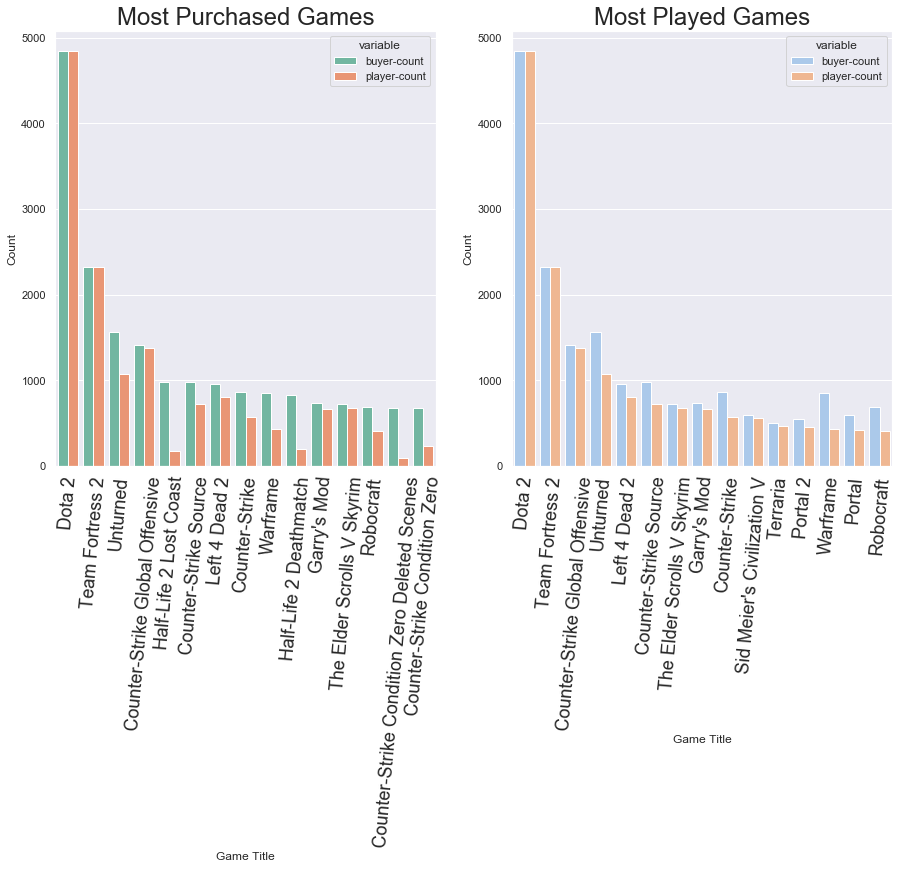

In [168]:
#create empty figure to lay figures on
fig, ax = plt.subplots(1,2, figsize=(15,8))

#create melted DataFrame to use varible column as seperate colors in grpah
games_df_head = games_stats_df.sort_values('buyer-count', ascending=False).head(15)
games_df_head["title"] = games_df_head.index
games_melt = games_df_head.melt(id_vars="title", value_vars=["buyer-count","player-count"])

#creates objuect on first ax
most_purch_game = sns.barplot(x="title",
            y="value",
            hue="variable",
            palette = "Set2",
            data=games_melt,
            ax= ax[0])

#chagnes format
most_purch_game.set_xticklabels(most_purch_game.get_xticklabels(), rotation=85, fontsize=18)
most_purch_game.set_xlabel('Game Title')
most_purch_game.set_ylabel('Count')
most_purch_game.set_title('Most Purchased Games', fontsize = 24)

#repeat steps for before, but look at top played games instead of most bought
games_df_head = games_stats_df.sort_values('player-count', ascending=False).head(15)
games_df_head["title"] = games_df_head.index
games_melt = games_df_head.melt(id_vars="title", value_vars=["buyer-count","player-count"])

#creates object on second ax
most_played_game = sns.barplot(x="title",
            y="value",
            hue="variable",
            palette = "pastel",
            data=games_melt,
            ax= ax[1])

#changes format
ax[1].set_xticklabels(most_played_game.get_xticklabels(), rotation=85, fontsize=18)
ax[1].set_xlabel('Game Title')
ax[1].set_ylabel('Count')
ax[1].set_title('Most Played Games', fontsize = 24)

#prints graph to screen
plt.show()

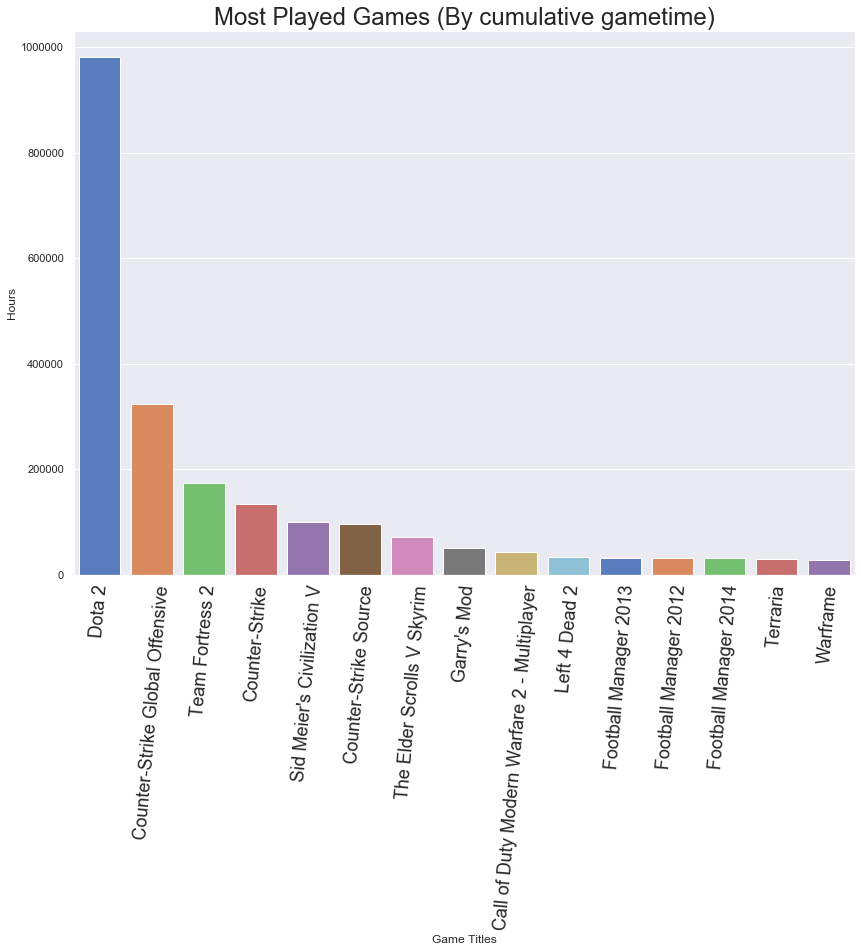

In [171]:
#repeat steps for before, but look at top played games, but looking at gametime instead of playercount
games_df_head = games_stats_df.sort_values('accumulated-hours-played', ascending=False).head(15)
games_df_head["title"] = games_df_head.index
games_melt = games_df_head.melt(id_vars="title", value_vars=["accumulated-hours-played"])

#creates object on second ax
most_played_game = sns.barplot(x="title",
            y="value",
            palette = "muted",
            data=games_melt)

#edits format
most_played_game.set_xticklabels(most_played_game.get_xticklabels(), rotation=85, fontsize=18)
most_played_game.set_xlabel('Game Titles')
most_played_game.set_ylabel('Hours')
most_played_game.set_title('Most Played Games (By cumulative gametime)', fontsize = 24)

plt.show()

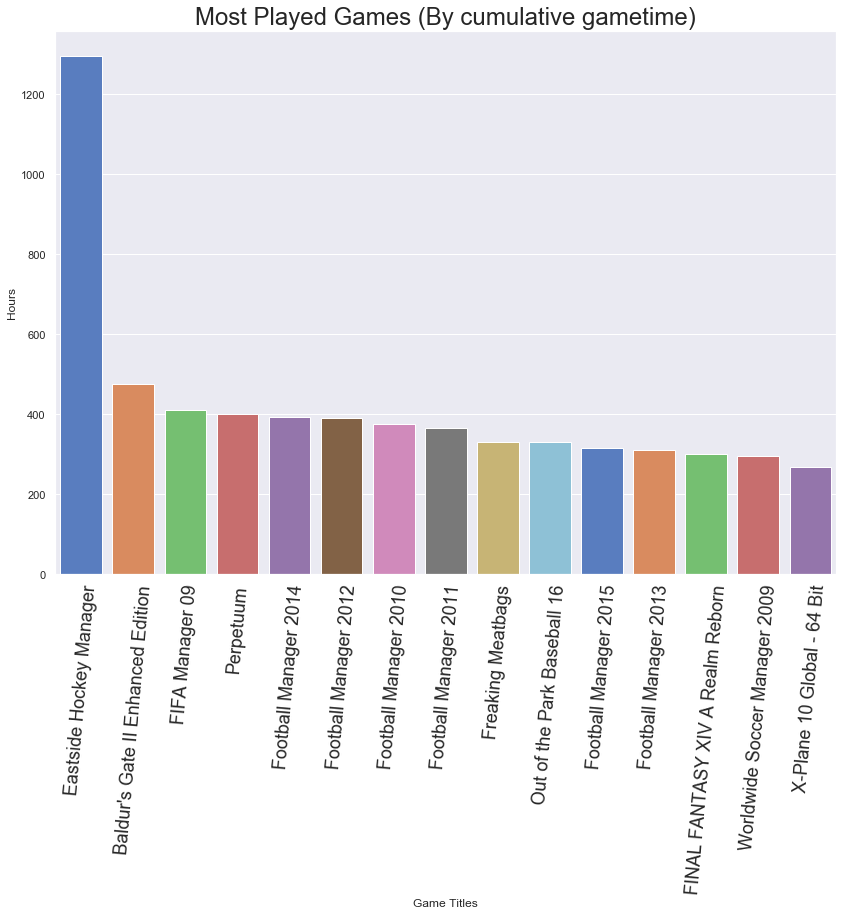

In [172]:
#repeat steps for before, but look at top played games, but looking at gametime instead of playercount
games_df_head = games_stats_df.sort_values('avg-hours-played', ascending=False).head(15)
games_df_head["title"] = games_df_head.index
games_melt = games_df_head.melt(id_vars="title", value_vars=['avg-hours-played'])

#creates object on second ax
most_played_game = sns.barplot(x="title",
            y="value",
            palette = "muted",
            data=games_melt)

#edits format
most_played_game.set_xticklabels(most_played_game.get_xticklabels(), rotation=85, fontsize=18)
most_played_game.set_xlabel('Game Titles')
most_played_game.set_ylabel('Hours')
most_played_game.set_title('Most Played Games (By cumulative gametime)', fontsize = 24)

plt.show()

In [7]:
import requests

In [17]:
r = requests.get('https://store.steampowered.com/api/appdetails?appids=218620')

r.json()['218620']

{'success': True,
 'data': {'type': 'game',
  'name': 'PAYDAY 2',
  'steam_appid': 218620,
  'required_age': '18',
  'is_free': False,
  'controller_support': 'full',
  'dlc': [1347750,
   1347751,
   1351060,
   1252200,
   1255151,
   1255150,
   1255152,
   826090,
   1184411,
   1184412,
   758420,
   1184410,
   612900,
   591710,
   548421,
   548422,
   548420,
   545100,
   487210,
   450660,
   468410,
   441600,
   433730,
   422400,
   401650,
   384020,
   384021,
   374301,
   374300,
   366660,
   368870,
   349830,
   358150,
   351890,
   348090,
   344140,
   339480,
   337661,
   337660,
   331900,
   323500,
   320030,
   311050,
   306690,
   259380,
   259381,
   275590,
   274161,
   267381,
   267380,
   264610,
   254260,
   330490,
   330491,
   330010,
   267382,
   288900,
   284430,
   271110,
   274160],
  'detailed_description': '<strong><a href="https://store.steampowered.com/bundle/13636/PAYDAY_2_San_Martn_Bundle/" target="_blank" rel="noreferrer"  >Look

In [27]:
pd.DataFrame(r.json()['218620'])

,success,data
about_the_game,True,"<strong><a href=""https://store.steampowered.co..."
achievements,True,"{'total': 1207, 'highlighted': [{'name': 'Comi..."
background,True,https://steamcdn-a.akamaihd.net/steam/apps/218...
categories,True,"[{'id': 2, 'description': 'Single-player'}, {'..."
content_descriptors,True,"{'ids': [], 'notes': None}"
controller_support,True,full
detailed_description,True,"<strong><a href=""https://store.steampowered.co..."
developers,True,[OVERKILL - a Starbreeze Studio.]
dlc,True,"[1347750, 1347751, 1351060, 1252200, 1255151, ..."
genres,True,"[{'id': '1', 'description': 'Action'}, {'id': ..."


In [28]:
r.json()['218620']['data']

{'type': 'game',
 'name': 'PAYDAY 2',
 'steam_appid': 218620,
 'required_age': '18',
 'is_free': False,
 'controller_support': 'full',
 'dlc': [1347750,
  1347751,
  1351060,
  1252200,
  1255151,
  1255150,
  1255152,
  826090,
  1184411,
  1184412,
  758420,
  1184410,
  612900,
  591710,
  548421,
  548422,
  548420,
  545100,
  487210,
  450660,
  468410,
  441600,
  433730,
  422400,
  401650,
  384020,
  384021,
  374301,
  374300,
  366660,
  368870,
  349830,
  358150,
  351890,
  348090,
  344140,
  339480,
  337661,
  337660,
  331900,
  323500,
  320030,
  311050,
  306690,
  259380,
  259381,
  275590,
  274161,
  267381,
  267380,
  264610,
  254260,
  330490,
  330491,
  330010,
  267382,
  288900,
  284430,
  271110,
  274160],
 'detailed_description': '<strong><a href="https://store.steampowered.com/bundle/13636/PAYDAY_2_San_Martn_Bundle/" target="_blank" rel="noreferrer"  >Looking for the San Martín Bundle? Click here!</a></strong><br><br>PAYDAY 2 is an action-packed, 